In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
sns.set()

# mount_point    = '/Users/fruity/Remote-AI-root/allen/aibs' #Rohan's mount point
mount_point    = '/allen/' #Corinne's mount point
data_dir       = mount_point + 'mat/Corinne/autoencoder/'
embeddings_dir = mount_point+'mat/Corinne/autoencoder/embeddings/'

In [2]:
#Load Corinne's data file:
dat_df=pd.read_csv(data_dir+'autoencoder_data_09_06_2019.csv', sep='#',low_memory=False)

#Separate out the annotations:
anno_df = dat_df[dat_df.keys().values[0:7]]
print('anno_df: ',anno_df.columns.values)

#Load embeddings:
mat = sio.loadmat(embeddings_dir+'std_data_run_0_cv_0_ng_500_pd_0-5_bs_1000_ld_2_ne_5000_ri_0-summary.mat',squeeze_me=True)

anno_df:  ['expt' 'pre_cell' 'post_cell' 'pre_cre' 'post_cre' 'pre_layer'
 'post_layer']


The features are sparsely populated. Only ~500 features have ~ at least 10% non-nans across cells.

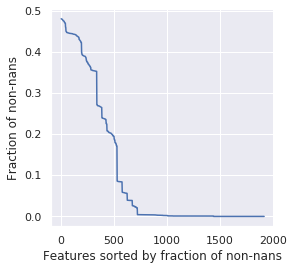

In [3]:
feature_list = dat_df.keys().values[7:]
data = dat_df[feature_list].values

#Fraction of non-nans per feature:
plt.figure(figsize=(4,4))
plt.plot(1 - np.sort(np.sum(np.isnan(data)/np.shape(data)[0],axis = 0)))
ax = plt.gca()
ax.set_ylabel('Fraction of non-nans')
ax.set_xlabel('Features sorted by fraction of non-nans')
plt.show()

In [4]:
#Feature indices sorted by fraction of nans:
keep_n_features = 500
ind = np.argsort(np.sum(np.isnan(data)/np.shape(data)[0],axis = 0))
keep = ind[0:keep_n_features] #Because sorting is in ascending order
data_sorted = data[:,keep]
mask_sorted = np.isnan(data_sorted).astype('float')
feature_list_sorted = feature_list[keep]

In [5]:
for f in feature_list_sorted: print(f)

('ic, 50.0, 0.25', 'latency', 2)
('ic, 50.0, 0.25', 'rise_time', 2)
('ic, 50.0, 0.25', 'amp', 4)
('ic, 50.0, 0.25', 'decay_tau', 2)
('ic, 50.0, 0.25', 'rise_time', 4)
('ic, 50.0, 0.25', 'latency', 4)
('ic, 50.0, 0.25', 'amp', 2)
('ic, 50.0, 0.25', 'decay_tau', 4)
('ic, 50.0, 0.25', 'rise_time', 3)
('ic, 50.0, 0.25', 'latency', 3)
('ic, 50.0, 0.25', 'amp', 3)
('ic, 50.0, 0.25', 'decay_tau', 3)
('ic, 50.0, 0.25', 'rise_time', 5)
('ic, 50.0, 0.25', 'amp', 5)
('ic, 50.0, 0.25', 'decay_tau', 5)
('ic, 50.0, 0.25', 'latency', 5)
('ic, 50.0, 0.25', 'rise_time', 10)
('ic, 50.0, 0.25', 'amp', 10)
('ic, 50.0, 0.25', 'latency', 10)
('ic, 50.0, 0.25', 'decay_tau', 10)
('ic, 50.0, 0.25', 'rise_time', 11)
('ic, 50.0, 0.25', 'latency', 11)
('ic, 50.0, 0.25', 'amp', 11)
('ic, 50.0, 0.25', 'decay_tau', 11)
('ic, 50.0, 0.25', 'amp', 6)
('ic, 50.0, 0.25', 'rise_time', 6)
('ic, 50.0, 0.25', 'decay_tau', 6)
('ic, 50.0, 0.25', 'latency', 6)
('ic, 50.0, 0.25', 'latency', 12)
('ic, 50.0, 0.25', 'decay_tau', 12

Data values are quite small; `median` values for the features is `~0.02`. 

Text(0.5, 0, 'Features')

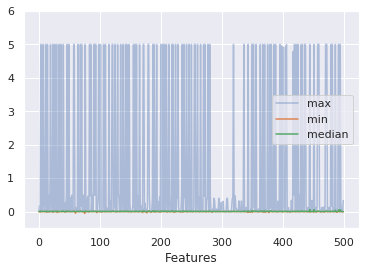

In [6]:
plt.figure()
plt.plot(np.nanmax(data_sorted,axis=0),alpha = 0.4,label='max')
plt.plot(np.nanmin(data_sorted,axis=0),alpha = 1,label='min')
plt.plot(np.nanmedian(data_sorted,axis=0),alpha = 1,label='median')
plt.legend()
ax = plt.gca()
ax.set_ylim(-0.5,6)
ax.set_xlabel('Features')

Final layer of the network is chosen to have a linear activation function since the dataset is standardized.

Text(0.5, 0, 'Feature values')

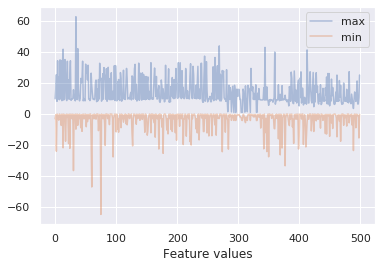

In [7]:
#Standardize data:
norm_data = (data_sorted - np.nanmean(data_sorted,axis=0))/(np.nanstd(data_sorted,axis=0)+1e-10)
plt.figure()
plt.plot(np.nanmax(norm_data,axis=0),alpha = 0.4,label='max')
plt.plot(np.nanmin(norm_data,axis=0),alpha = 0.4,label='min')
plt.legend()
ax = plt.gca()
ax.set_xlabel('Features')
ax.set_xlabel('Feature values')

Assign numeric ids to unique rows. `1000` is assigned to any rows containing `unknown` or `nan`

In [8]:
#Append z to the annotations:
anno_df = anno_df.assign(z0=mat['z'][:,0])
anno_df = anno_df.assign(z1=mat['z'][:,1])

Select rows that don't have unknown or nan labels

In [9]:
#Create a single label by concatenating pre_cre,post_cre,pre_layer, and post_layer labels
anno_df = anno_df.assign(combined_anno=(anno_df['pre_cre'].map(str) + '_' + anno_df['post_cre'].map(str) + '_' 
                   +anno_df['pre_layer'].map(str) +'_' +anno_df['post_layer'].map(str)).astype('str'))

#Assign numeric id to 'combined_anno'
anno_df = anno_df.assign(id=(anno_df['combined_anno']).astype('category').cat.codes)
anno_df.loc[anno_df['combined_anno'].str.contains('unknown') | anno_df['combined_anno'].str.contains('nan'),'id']=1000

#Select only cells with no nans or unkowns in the annotation columns.
X = anno_df.loc[anno_df['id'].values!=1000,['z0','z1','id','pre_post_cre','combined_anno','pre_cell','post_cell','pre_cre','post_cre','pre_layer','post_layer']]

/home/corinnet/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Next block keeps all the rows in the dataset

In [10]:
#Create a single label by concatenating pre_cre and post_cre labels
anno_df = anno_df.assign(pre_post_cre=(anno_df['pre_cre'].map(str) + '_' + anno_df['post_cre'].map(str)))
X = anno_df
# change columns to strings incase there is a nan
for anno in ['pre_cell','post_cell','pre_cre','post_cre','pre_layer','post_layer']:
    X[anno]=X[anno].astype('str')

In [11]:
#Number of rows for each unique annotation:
for i in ['pre_cell','post_cell','pre_cre','post_cre','pre_layer','post_layer','pre_post_cre']:
    print('\n-----')
    print(X[i].value_counts())


-----
7    4146
8    4001
2    3989
6    3950
3    3826
1    3754
5    3213
4    2974
Name: pre_cell, dtype: int64

-----
8    4138
2    4015
6    3956
3    3943
4    3726
7    3685
5    3209
1    3181
Name: post_cell, dtype: int64

-----
unknown       11556
pvalb          8198
sst            3801
tlx3           1655
sim1           1619
nr5a1           914
vip             841
rorb            600
ntsr1           359
slc17a8         100
rbp4             90
cux2             60
pvalb,sst        30
pvalb,sim1       30
Name: pre_cre, dtype: int64

-----
unknown    10869
pvalb       7942
sst         3402
sim1        2109
tlx3        1581
vip         1471
nr5a1       1114
rorb         660
ntsr1        440
rbp4          90
slc17a8       85
cux2          45
fam84b        45
Name: post_cre, dtype: int64

-----
5      11235
2/3     7859
4       3880
6       2999
3       2394
2       1125
nan      361
Name: pre_layer, dtype: int64

-----
5      11013
2/3     7977
4       3979
6       2899
3       

pre_cell
1
2
3
4
5
6
7
8


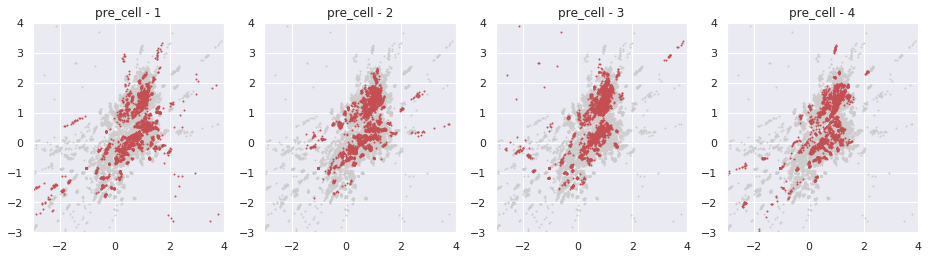

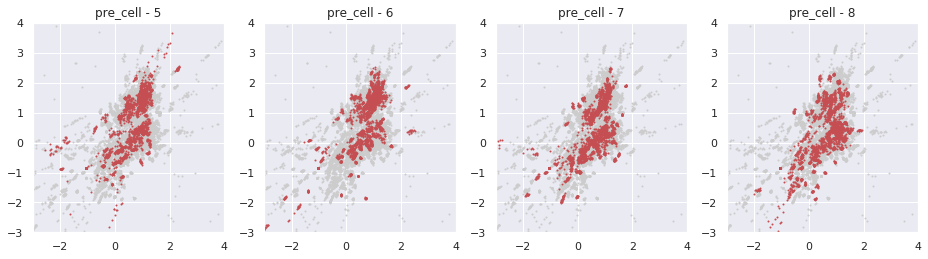

post_cell
1
2
3
4
5
6
7
8


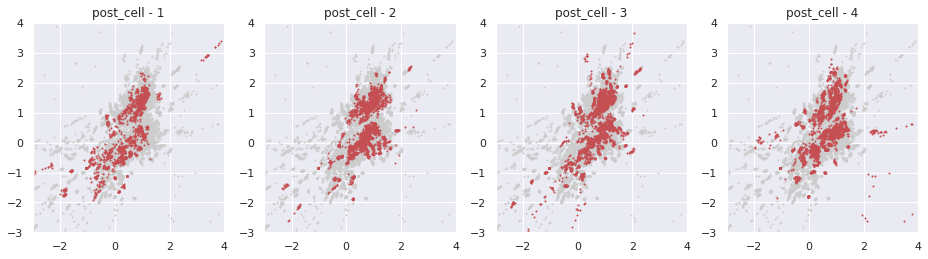

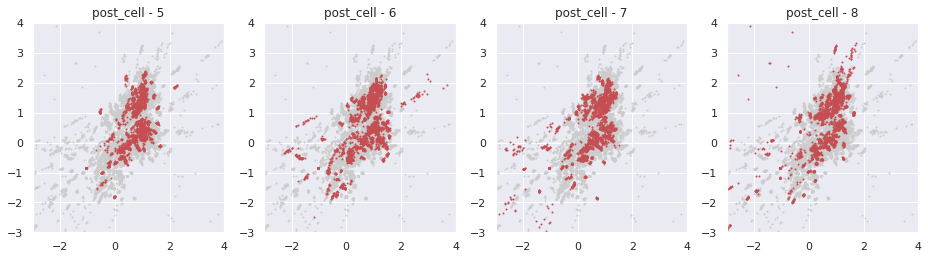

pre_cre
cux2
nr5a1
ntsr1
pvalb
pvalb,sim1
pvalb,sst
rbp4
rorb
sim1
slc17a8
sst
tlx3
unknown
vip


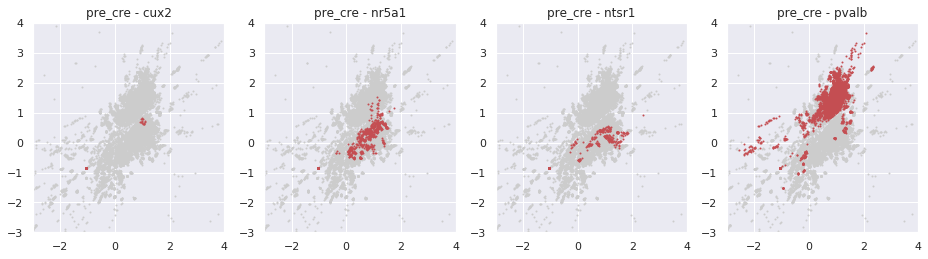

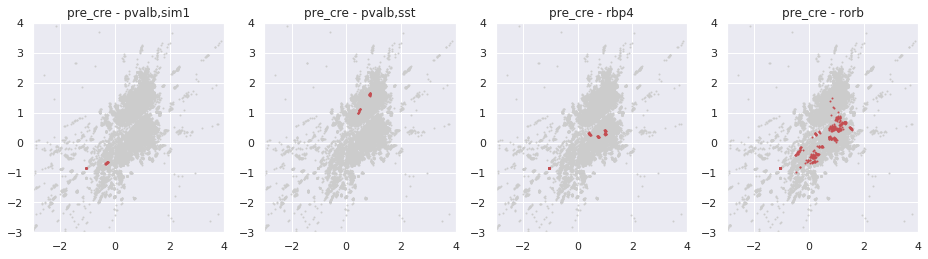

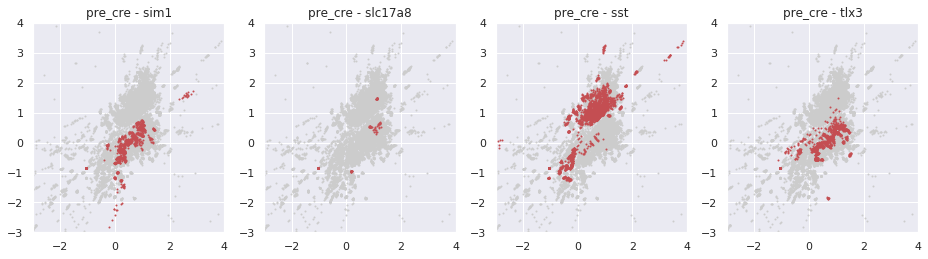

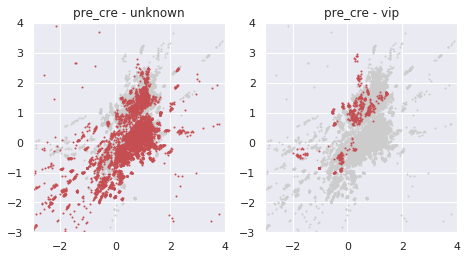

post_cre
cux2
fam84b
nr5a1
ntsr1
pvalb
rbp4
rorb
sim1
slc17a8
sst
tlx3
unknown
vip


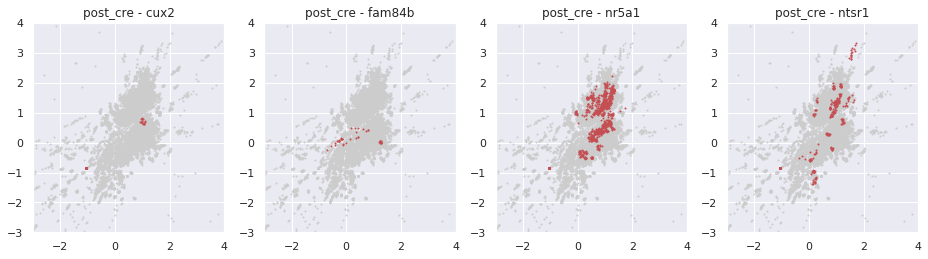

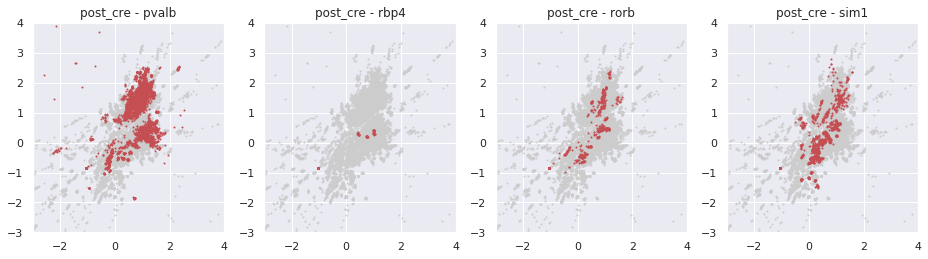

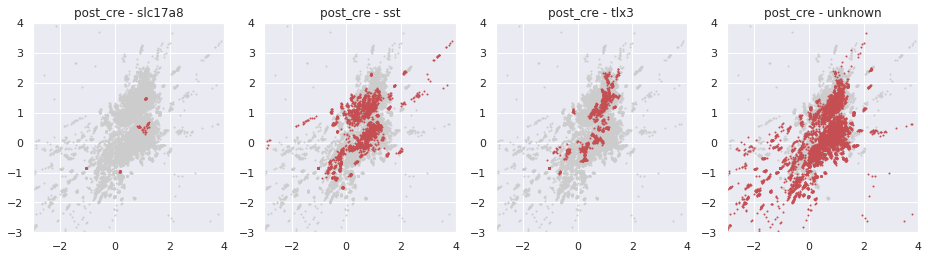

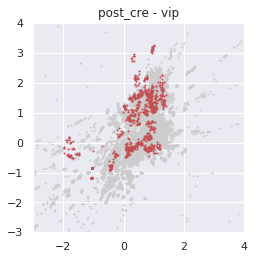

pre_layer
2
2/3
3
4
5
6
nan


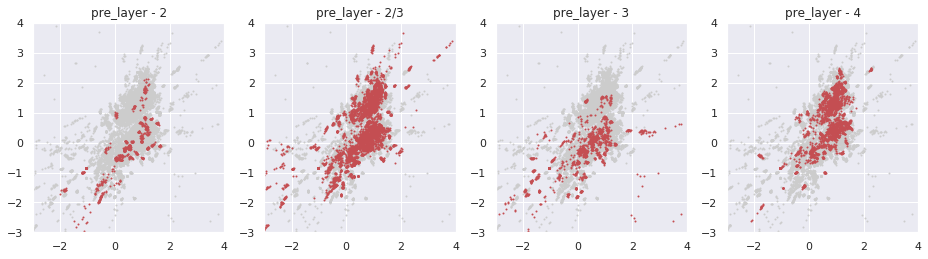

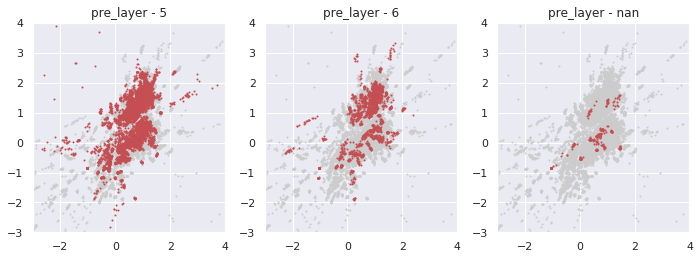

post_layer
2
2/3
3
4
5
6
nan


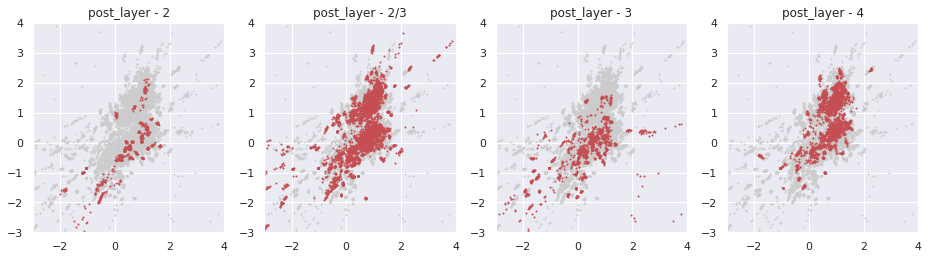

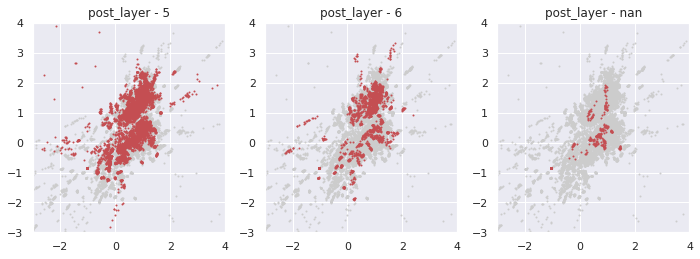

In [12]:
#For each every unique label in list 'anno_type', plot scatter maps:
for annotype in ['pre_cell','post_cell','pre_cre','post_cre','pre_layer','post_layer']:
    i=0
    print(annotype)
    for label in np.unique(X[annotype]):
        print(label)
        if i%4==0:
            plt.figure(figsize=(13,3.7))
            i=0
        plt.subplot(1,4,i+1)
        ind = X[annotype]==label
        plt.scatter(X['z0'][~ind],X['z1'][~ind],s=1,c='#CCCCCC',alpha=1)
        plt.scatter(X['z0'][ind],X['z1'][ind],s=1,c='r',alpha=1)
        ax = plt.gca()
        ax.set_xlim(-3,4)
        ax.set_ylim(-3,4)
        ax.set_title(str(annotype)+' - '+str(label))  
        i=i+1
        plt.tight_layout()
    plt.show()

<Figure size 936x3600 with 0 Axes>

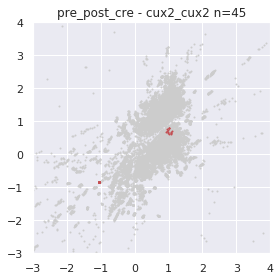

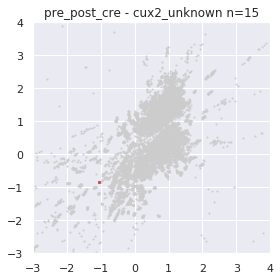

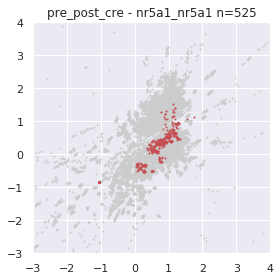

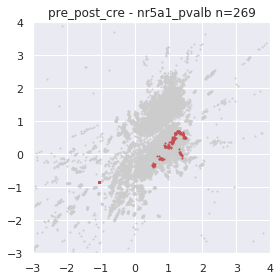

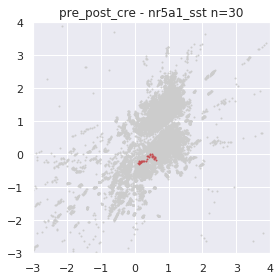

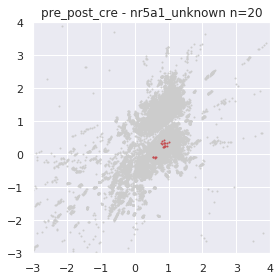

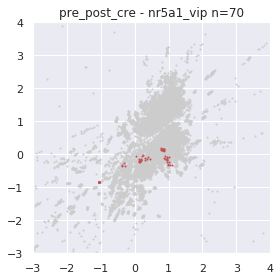

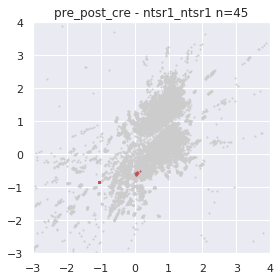

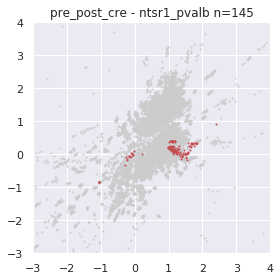

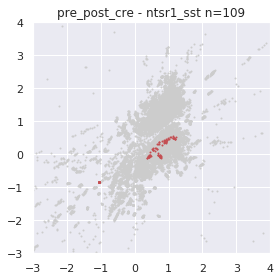

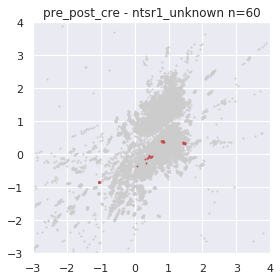

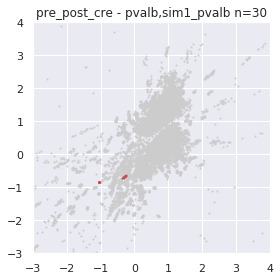

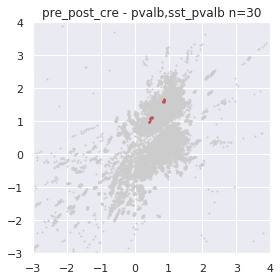

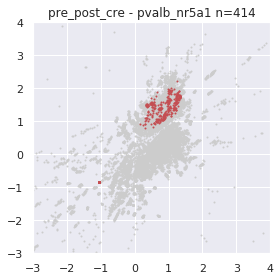

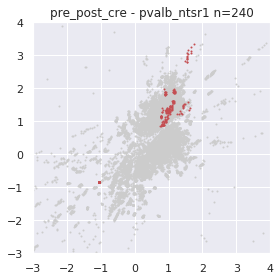

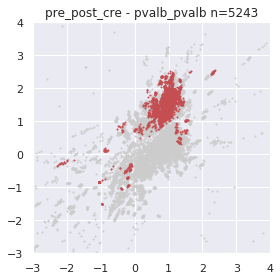

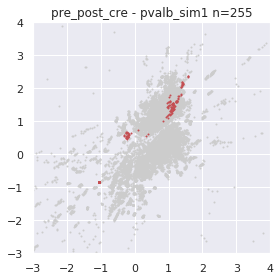

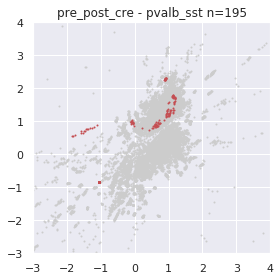

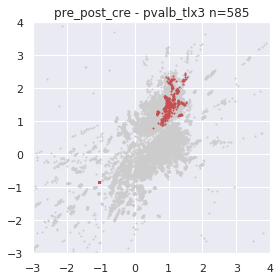

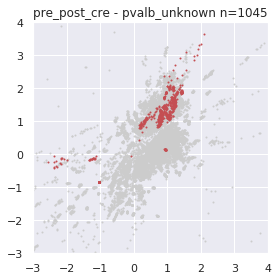

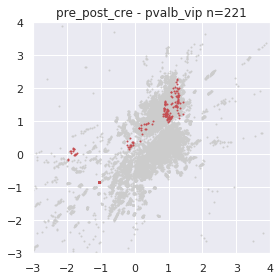

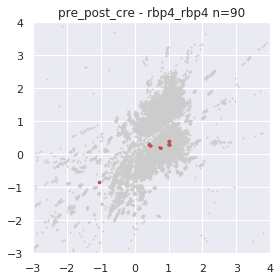

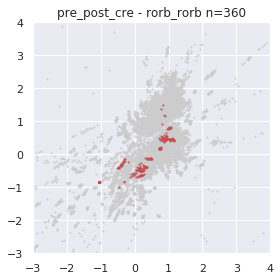

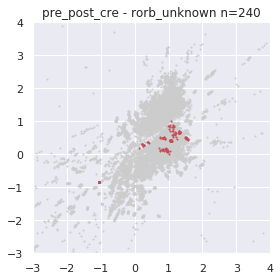

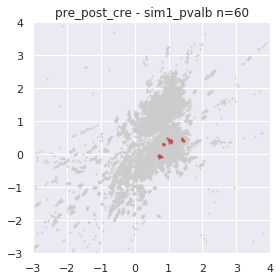

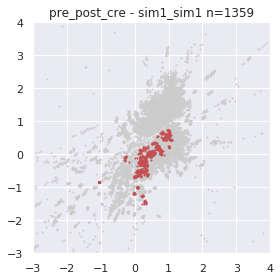

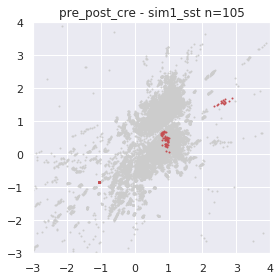

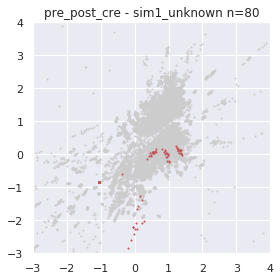

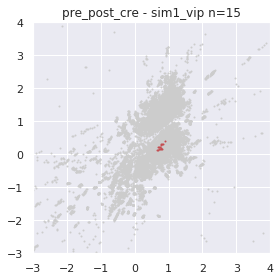

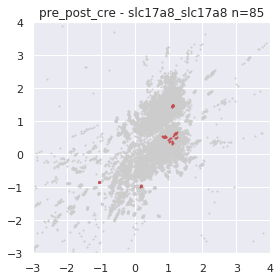

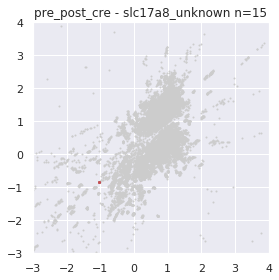

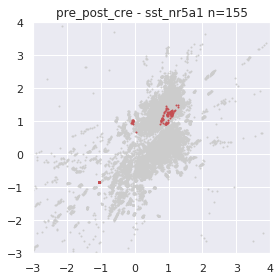

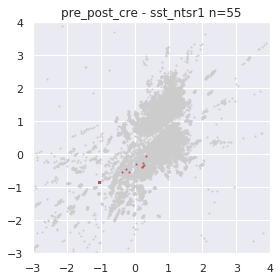

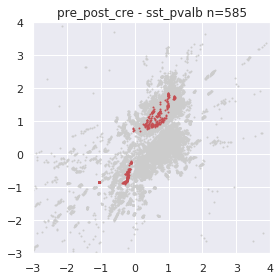

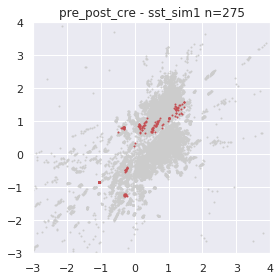

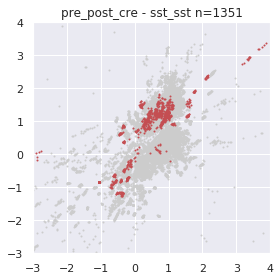

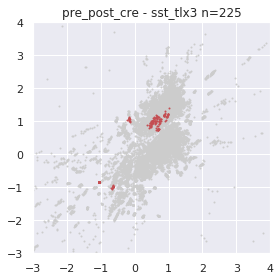

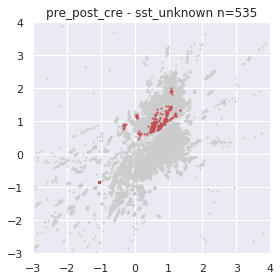

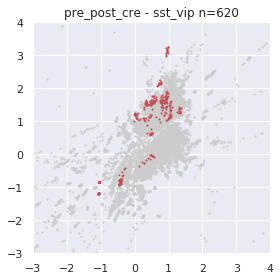

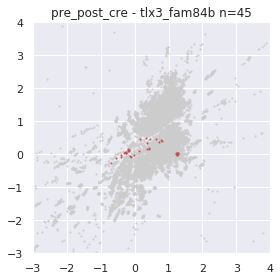

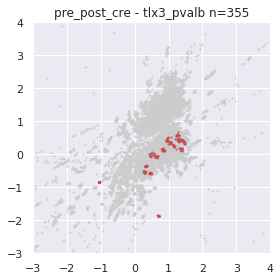

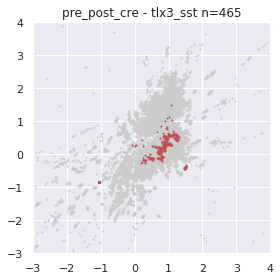

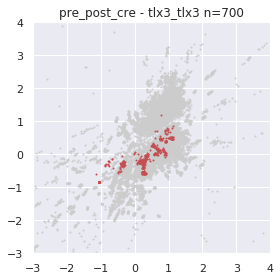

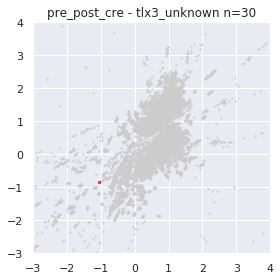

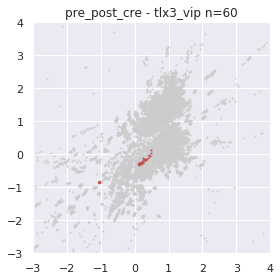

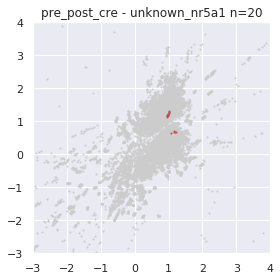

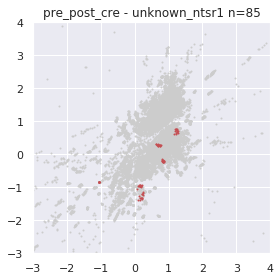

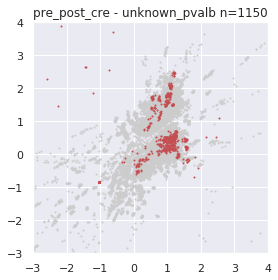

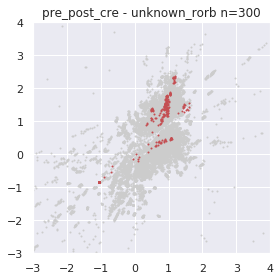

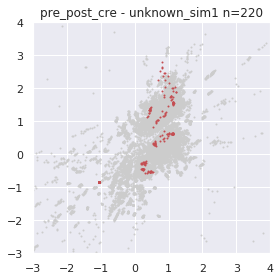

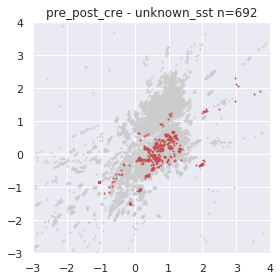

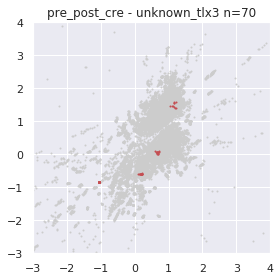

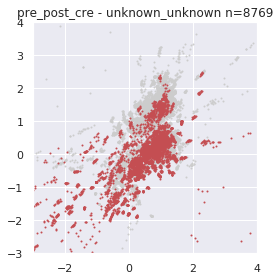

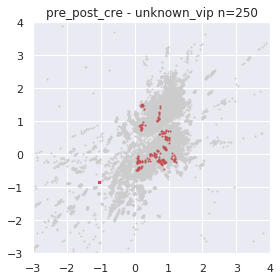

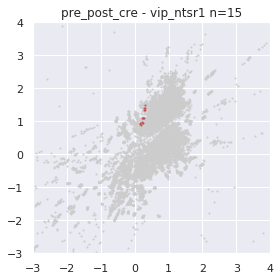

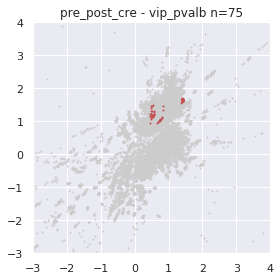

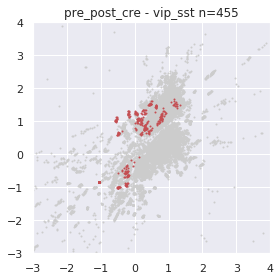

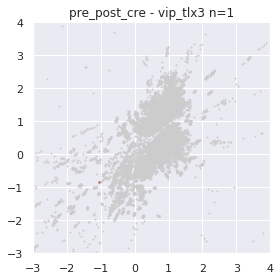

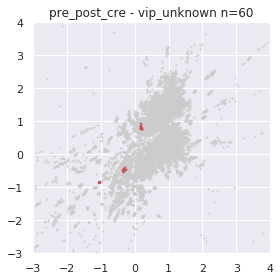

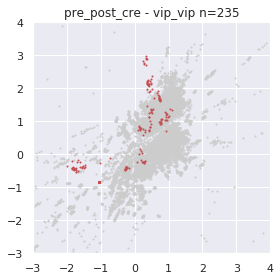

In [13]:
plt.figure(figsize=(13,50))
for annotype in ['pre_post_cre']:
    for label in np.unique(X[annotype]):
        plt.figure(figsize=(4,4))
        ind = X[annotype]==label
        plt.scatter(X['z0'][~ind],X['z1'][~ind],s=1,c='#CCCCCC',alpha=1)
        plt.scatter(X['z0'][ind],X['z1'][ind],s=1,c='r',alpha=1)
        
        ax = plt.gca()
        ax.set_xlim(-3,4)
        ax.set_ylim(-3,4)
        idx = str(annotype)+' - '+str(label)
        ax.set_title(idx+' n='+str(np.sum(ind)))
       
        plt.tight_layout()
        fname = ('./pre_post_cre/{}.png').format(idx)

        #plt.savefig(fname,dpi=600)
        plt.show()
        plt.close()
        

In [ ]:
# #Use joins to combine labels
# pre_layer_df = pd.DataFrame({'pre_layer':['2/3','4','5','6'],
#                              'pre_layer_color':[1,2,3,4]})
# X = X.join(pre_layer_df.set_index('pre_layer'), on='pre_layer')
# X = X.join(post_layer_df.set_index('post_layer'), on='post_layer')
# X = X.join(pre_cre_df.set_index('pre_cre'), on='pre_cre')
# X = X.join(post_cre_df.set_index('post_cre'), on='post_cre')

In [ ]:
# #Sanity check for network training:
# loss = pd.read_csv(data_dir+'logs/std_data_run_0_cv_0_ng_500_pd_0-5_bs_1000_ld_2_ne_5000_ri_0.csv',sep=',')
# plt.figure(figsize = (3,3))
# plt.plot(loss['epoch'],loss['loss'],label='Train')
# plt.plot(loss['epoch'],loss['val_loss'],label='Val')
# ax = plt.gca()
# ax.set_xlabel('Epochs')
# ax.set_ylabel('Masked MSE')
# ax.set_ylim(0.13,0.16)
# plt.legend()
# plt.show()